Welcome to the Stock Advisor Chatbot!
Ask a question (or type 'exit' to quit): should I buy AAPL stock
Ticker found: AAPL


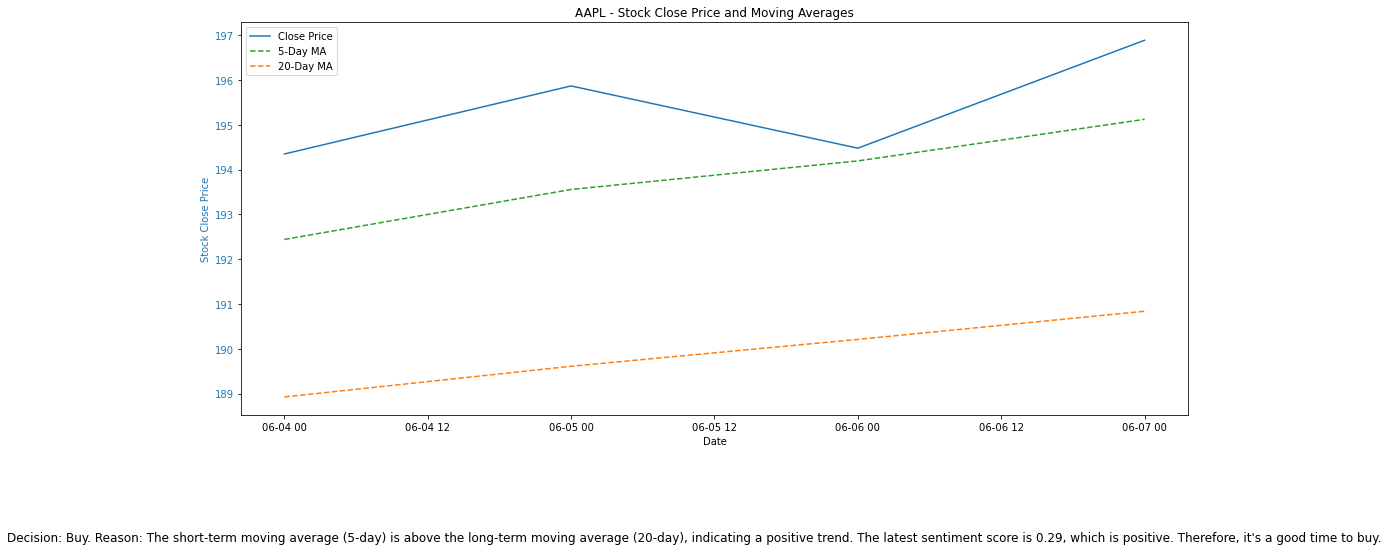

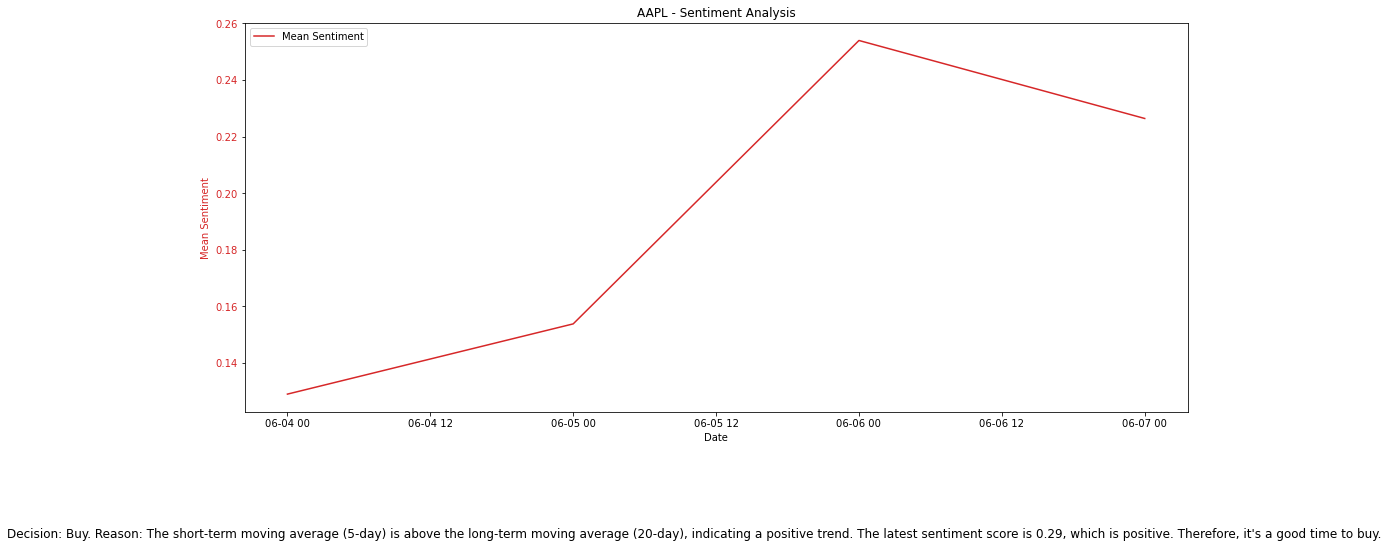

Decision for AAPL: Buy. Reason: The short-term moving average (5-day) is above the long-term moving average (20-day), indicating a positive trend. The latest sentiment score is 0.29, which is positive. Therefore, it's a good time to buy.
Ask a question (or type 'exit' to quit): exit
Goodbye!


In [4]:
import logging
import requests
from datetime import datetime, timedelta
import pandas as pd
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
import yfinance as yf
import matplotlib.pyplot as plt
import spacy
import re

# Configure logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)  # Only show errors and critical logs

# Define a handler to control the output
handler = logging.StreamHandler()
formatter = logging.Formatter('%(levelname)s:%(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

# Suppress yfinance logger to avoid printing errors to the user
yf_logger = logging.getLogger('yfinance')
yf_logger.setLevel(logging.CRITICAL)

class StockAdvisorBot:
    def __init__(self, api_key, model_name='yiyanghkust/finbert-tone'):
        self.api_key = api_key
        self.model_name = model_name
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.finbert = pipeline("sentiment-analysis", model=self.model, tokenizer=self.tokenizer)
        self.nlp = spacy.load('en_core_web_sm')

    def fetch_finnhub_news(self, ticker):
        try:
            end_date = datetime.now()
            start_date = end_date - timedelta(days=30)
            url = f"https://finnhub.io/api/v1/company-news?symbol={ticker}&from={start_date.strftime('%Y-%m-%d')}&to={end_date.strftime('%Y-%m-%d')}&token={self.api_key}"
            
            response = requests.get(url)
            response.raise_for_status()
            
            news_items = response.json()
            return news_items
        except requests.exceptions.RequestException as e:
            logger.error(f"Failed to fetch news for {ticker}: {e}")
            return []

    def analyze_finbert_sentiment(self, text):
        results = self.finbert(text)
        return results

    def create_sentiment_df(self, news_items):
        sentiments = []
        for item in news_items:
            if 'headline' in item:
                sentiment_result = self.analyze_finbert_sentiment(item['headline'])
                if sentiment_result:
                    sentiment_label = sentiment_result[0]['label']
                    sentiment_score = sentiment_result[0]['score']
                    sentiment_date = datetime.fromtimestamp(item['datetime']).strftime('%Y-%m-%d')
                    sentiments.append({'date': sentiment_date, 'label': sentiment_label, 'score': sentiment_score})
        
        sentiment_df = pd.DataFrame(sentiments)
        sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
        
        # Encode sentiments
        sentiment_encoding = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
        sentiment_df['encoded_label'] = sentiment_df['label'].map(sentiment_encoding)
        
        return sentiment_df.groupby('date')['encoded_label'].mean().reset_index(name='mean_sentiment')

    def get_stock_data(self, ticker, period='1mo', interval='1d'):
        stock = yf.Ticker(ticker)
        hist = stock.history(period=period, interval=interval)
        return hist

    def fetch_stock_prices(self, ticker):
        try:
            df = self.get_stock_data(ticker, period='3mo', interval='1d')
            if df.empty:
                logger.warning(f"Failed to fetch stock prices for {ticker}")
            return df
        except Exception as e:
            logger.error(f"Error fetching stock prices for {ticker}: {e}")
            return pd.DataFrame()

    def validate_ticker(self, ticker):
        try:
            df = self.get_stock_data(ticker, period='1d', interval='1d')
            is_valid = not df.empty
            if is_valid:
                print(f"Ticker found: {ticker}")
            return is_valid
        except Exception as e:
            return False

    def plot_data(self, sentiment_df, stock_data, ticker, decision, explanation):
        # Normalize the time part of the datetime index and remove timezone information
        stock_data.index = stock_data.index.normalize().tz_localize(None)

        # Merge the sentiment data with stock data on dates
        merged_df = pd.merge(sentiment_df, stock_data, left_on='date', right_index=True)

        # Ensure the 'date' column is in the correct format for plotting
        merged_df['date'] = pd.to_datetime(merged_df['date'])

        # Plotting the stock price and moving averages
        fig, ax1 = plt.subplots(figsize=(14, 7))
        ax1.set_xlabel('Date')
        ax1.set_ylabel('Stock Close Price', color='tab:blue')
        ax1.plot(merged_df['date'].values, merged_df['Close'].values, color='tab:blue', label='Close Price')
        ax1.plot(merged_df['date'].values, merged_df['Short_MA'].values, color='tab:green', linestyle='--', label='5-Day MA')
        ax1.plot(merged_df['date'].values, merged_df['Long_MA'].values, color='tab:orange', linestyle='--', label='20-Day MA')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        ax1.legend(loc='upper left')
        fig.tight_layout()
        plt.title(f'{ticker} - Stock Close Price and Moving Averages')
        plt.figtext(0.5, -0.05, f'Decision: {decision}. Reason: {explanation}', wrap=True, horizontalalignment='center', fontsize=12)
        fig.subplots_adjust(bottom=0.2)
        plt.show()

        # Plotting the sentiment data
        fig, ax2 = plt.subplots(figsize=(14, 7))
        ax2.set_xlabel('Date')
        ax2.set_ylabel('Mean Sentiment', color='tab:red')
        ax2.plot(merged_df['date'].values, merged_df['mean_sentiment'].values, color='tab:red', label='Mean Sentiment')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        ax2.legend(loc='upper left')
        fig.tight_layout()
        plt.title(f'{ticker} - Sentiment Analysis')
        plt.figtext(0.5, -0.05, f'Decision: {decision}. Reason: {explanation}', wrap=True, horizontalalignment='center', fontsize=12)
        fig.subplots_adjust(bottom=0.2)
        plt.show()

    def process_input(self, user_input):
        # Use regex to find stock ticker patterns (1-5 uppercase letters surrounded by word boundaries)
        pattern = r'\b[A-Z]{1,5}\b'
        matches = re.findall(pattern, user_input)
        valid_tickers = []
        
        for match in matches:
            is_valid = self.validate_ticker(match)
            if is_valid:
                valid_tickers.append(match)
        
        if valid_tickers:
            ticker = valid_tickers[0]
        else:
            ticker = None

        intent = None
        if "buy" in user_input or "sell" in user_input or "hold" in user_input:
            intent = "advice"
        elif "price" in user_input or "stock" in user_input:
            intent = "price"
        elif "news" in user_input or "sentiment" in user_input:
            intent = "sentiment"

        return intent, ticker

    def make_decision(self, ticker):
        stock_data = self.fetch_stock_prices(ticker)
        if stock_data.empty:
            return "Insufficient stock data to make a decision."
        
        news_items = self.fetch_finnhub_news(ticker)
        if not news_items:
            return "Insufficient news data to make a decision."

        sentiment_df = self.create_sentiment_df(news_items)

        # Calculate moving averages
        stock_data['Short_MA'] = stock_data['Close'].rolling(window=5).mean()
        stock_data['Long_MA'] = stock_data['Close'].rolling(window=20).mean()

        # Determine the latest sentiment
        latest_sentiment = sentiment_df.iloc[-1]['mean_sentiment'] if not sentiment_df.empty else 0

        # Determine signals and provide explanations
        explanation = []
        if stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1]:
            explanation.append("The short-term moving average (5-day) is above the long-term moving average (20-day), indicating a positive trend.")
        else:
            explanation.append("The short-term moving average (5-day) is below the long-term moving average (20-day), indicating a negative trend.")

        if latest_sentiment > 0:
            explanation.append(f"The latest sentiment score is {latest_sentiment:.2f}, which is positive.")
        elif latest_sentiment < 0:
            explanation.append(f"The latest sentiment score is {latest_sentiment:.2f}, which is negative.")
        else:
            explanation.append(f"The latest sentiment score is {latest_sentiment:.2f}, which is neutral.")

        if stock_data['Short_MA'].iloc[-1] > stock_data['Long_MA'].iloc[-1] and latest_sentiment > 0:
            decision = "Buy"
            explanation.append("Therefore, it's a good time to buy.")
        elif stock_data['Short_MA'].iloc[-1] < stock_data['Long_MA'].iloc[-1] and latest_sentiment < 0:
            decision = "Sell"
            explanation.append("Therefore, it's a good time to sell.")
        else:
            decision = "Hold"
            explanation.append("Therefore, it's better to hold for now.")

        # Combine explanations into a single string
        explanation_str = " ".join(explanation)

        # Plot the data with the decision and explanation
        self.plot_data(sentiment_df, stock_data, ticker, decision, explanation_str)

        return f"{decision}. Reason: {explanation_str}"

# Example usage
if __name__ == "__main__":
    api_key = "cnkfihhr01qiclq85a0gcnkfihhr01qiclq85a10"
    bot = StockAdvisorBot(api_key)

    print("Welcome to the Stock Advisor Chatbot!")
    while True:
        user_input = input("Ask a question (or type 'exit' to quit): ")
        if user_input.lower() == 'exit':
            break

        intent, ticker = bot.process_input(user_input)
        if not ticker:
            print("I couldn't find a valid stock ticker in your input. Please try again.")
            continue

        if intent == "price":
            stock_data = bot.fetch_stock_prices(ticker)
            if stock_data.empty:
                print("No data found for the given ticker.")
            else:
                print(stock_data)
        elif intent == "sentiment":
            news_items = bot.fetch_finnhub_news(ticker)
            if news_items:
                sentiment_df = bot.create_sentiment_df(news_items)
                stock_data = bot.fetch_stock_prices(ticker)
                bot.plot_data(sentiment_df, stock_data, ticker, "", "")
            else:
                print("No news found for the given ticker.")
        elif intent == "advice":
            decision = bot.make_decision(ticker)
            print(f"Decision for {ticker}: {decision}")
        else:
            print("I'm sorry, I didn't understand that. Please ask about stock prices, news sentiment, or advice on buy/sell/hold.")

    print("Goodbye!")


